In [1]:
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import os
import torchmetrics
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

c:\users\simon\miniconda3\envs\air\lib\site-packages\pytorch_lightning\metrics\__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [50]:
data_path = Path("data")

In [76]:
df_seoul = pd.read_csv(data_path / "df_seoul.tsv", encoding="utf-8", sep="\t")
df_baek = pd.read_csv(data_path / "df_baek.tsv", encoding="utf-8", sep="\t")
df_traffic = pd.read_csv(data_path / "traffic_filled_by_gu_2018-2020.tsv", encoding="utf-8", sep="\t")

df_seoul["date"] = pd.to_datetime(df_seoul["date"])
df_baek["date"] = pd.to_datetime(df_baek["date"])
df_traffic["date"] = pd.to_datetime(df_traffic["date"])

df_seoul = df_seoul.merge(df_traffic, on=["date", "district"])

In [77]:
print(f"Seoul Data: {df_seoul.shape}")
print(f"Baek Data: {df_baek.shape}")

Seoul Data: (631296, 18)
Baek Data: (26304, 17)


In [78]:
df_seoul.isnull().sum()

district                   0
date                       0
SO2                        0
CO                         0
O3                         0
NO2                        0
PM10                       0
PM25                       0
PM10_AQI                   0
PM25_AQI                   0
temperature                0
precipitation              0
windSpeed                  0
windDirection              0
humidity                   0
spotAtmosphericPressure    0
groundTemperature          0
traffic                    0
dtype: int64

In [79]:
df_baek.isnull().sum()

district                   0
date                       0
SO2                        0
CO                         0
O3                         0
NO2                        0
PM10                       0
PM25                       0
PM10_AQI                   0
PM25_AQI                   0
temperature                0
precipitation              0
windSpeed                  0
windDirection              0
humidity                   0
spotAtmosphericPressure    0
groundTemperature          0
dtype: int64

## convert to category


https://www.airnow.gov/aqi/aqi-basics/

|Daily AQI Color|Levels of Concern|Values of Index|Description of Air Quality
|---|---|---|---
|Green|Good|0 to 50|Air quality is satisfactory, and air pollution poses little or no risk.
|Yellow|Moderate|51 to 100|Air quality is acceptable. However, there may be a risk for some people, particularly those who are unusually sensitive to air pollution.
|Orange|Unhealthy for Sensitive Groups|101 to 150|Members of sensitive groups may experience health effects. The general public is less likely to be affected.
|Red|Unhealthy|151 to 200|Some members of the general public may experience health effects; members of sensitive groups may experience more serious health effects.
|Purple|Very Unhealthy|201 to 300|Health alert: The risk of health effects is increased for everyone.
|Maroon|Hazardous|301 and higher|Health warning of emergency conditions: everyone is more likely to be affected.

In [80]:
def get_aqi_cate(c):
    if (c >= 0) and (c <= 50):
        return 0
    elif (c > 50) and (c <= 100):
        return 1
    elif (c > 100) and (c <= 150):
        return 2
    elif (c > 150) and (c <= 200):
        return 3
    elif (c > 200) and (c <= 300):
        return 4
    elif (c > 300):
        return 5
    else:
        return -1

In [81]:
df_seoul["PM10_AQI_CATE"] = df_seoul["PM10_AQI"].apply(get_aqi_cate)
df_seoul["PM25_AQI_CATE"] = df_seoul["PM25_AQI"].apply(get_aqi_cate)
df_baek["PM10_AQI_CATE"] = df_baek["PM10_AQI"].apply(get_aqi_cate)
df_baek["PM25_AQI_CATE"] = df_baek["PM25_AQI"].apply(get_aqi_cate)

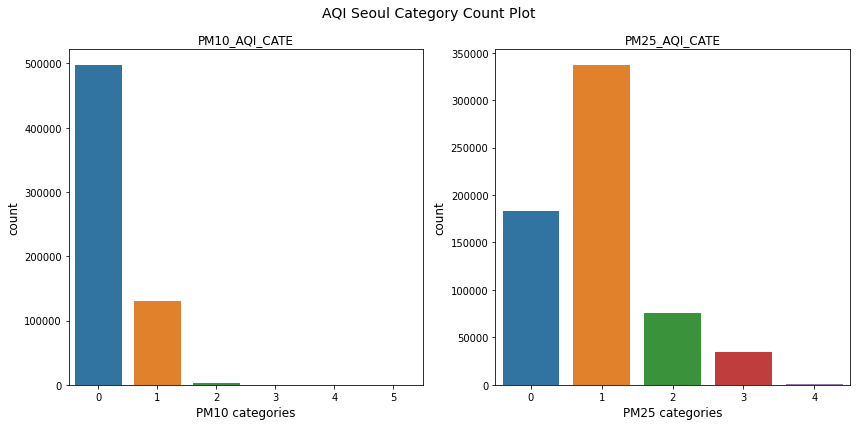

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, x in zip(axes.flatten(), ["PM10_AQI_CATE", "PM25_AQI_CATE"]):
    sns.countplot(x=x, data=df_seoul, ax=ax)
    ax.set_title(f"{x}", fontsize=12)
    ax.set_xlabel(f"{x.split('_')[0]} categories", fontsize=12)
    ax.set_ylabel("count", fontsize=12)
fig.suptitle("AQI Seoul Category Count Plot", fontsize=14)
plt.tight_layout()
plt.show()

fig.savefig("AQI Seoul Category Count Plot.png")

In [83]:
pm10_cnts = np.unique(df_seoul["PM10_AQI_CATE"].values, return_counts=True)[1]
pm10_cnts = list(pm10_cnts) + [0]*(6-len(pm10_cnts))
pm25_cnts = np.unique(df_seoul["PM25_AQI_CATE"].values, return_counts=True)[1]
pm25_cnts = list(pm25_cnts) + [0]*(6-len(pm25_cnts))

In [84]:
pickle.dump([pm10_cnts, pm25_cnts], (data_path / "class_weight.pickle").open("wb"))

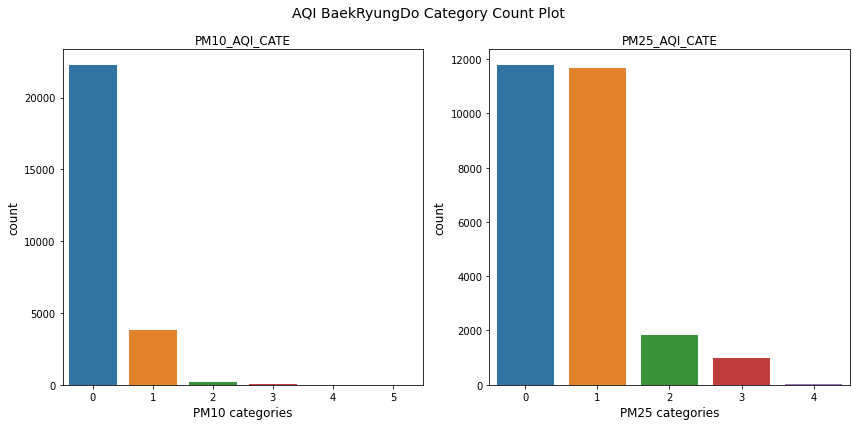

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, x in zip(axes.flatten(), ["PM10_AQI_CATE", "PM25_AQI_CATE"]):
    sns.countplot(x=x, data=df_baek, ax=ax)
    ax.set_title(f"{x}", fontsize=12)
    ax.set_xlabel(f"{x.split('_')[0]} categories", fontsize=12)
    ax.set_ylabel("count", fontsize=12)
fig.suptitle("AQI BaekRyungDo Category Count Plot", fontsize=14)
plt.tight_layout()
plt.show()

fig.savefig("AQI BaekRyungDo Category Count Plot.png")

## Encode district to number

In [86]:
# Check if all the district is exist
np.isin(df_seoul["district"].unique(), df_traffic["district"].unique())

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [87]:
idx2gu = dict(enumerate(df_seoul["district"].unique()))
idx2gu[len(idx2gu)] = df_baek["district"].unique()[0]  # add baek district
gu2idx = {v: k for k, v in idx2gu.items()}
gu2idx

{'강남구': 0,
 '강동구': 1,
 '강서구': 2,
 '관악구': 3,
 '광진구': 4,
 '구로구': 5,
 '금천구': 6,
 '노원구': 7,
 '도봉구': 8,
 '동대문구': 9,
 '동작구': 10,
 '마포구': 11,
 '서대문구': 12,
 '서초구': 13,
 '성동구': 14,
 '성북구': 15,
 '송파구': 16,
 '양천구': 17,
 '영등포구': 18,
 '용산구': 19,
 '은평구': 20,
 '종로구': 21,
 '중구': 22,
 '중랑구': 23,
 '백령도': 24}

In [88]:
pickle.dump(gu2idx, (data_path / "gu2idx.pickle").open("wb"))

In [89]:
df_seoul["district"] = df_seoul.loc[:, "district"].apply(gu2idx.get)
df_baek["district"] = df_baek.loc[:, "district"].apply(gu2idx.get)

## Train & Test data Split

2018~2019 for train / 2020 for test

In [90]:
seoul_test_mask = df_seoul["date"].dt.year == 2020
baek_test_mask = df_baek["date"].dt.year == 2020

In [91]:
df_train_seoul = df_seoul.loc[~seoul_test_mask, :]
df_test_seoul = df_seoul.loc[seoul_test_mask, :]

df_train_baek = df_baek.loc[~baek_test_mask, :]
df_test_baek = df_baek.loc[baek_test_mask, :]

In [92]:
input_cols = [
    'district', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'PM10_AQI', 'PM25_AQI', 
    'temperature', 'precipitation', 'windSpeed','windDirection', 'humidity', 'spotAtmosphericPressure', 'groundTemperature', 'traffic'
]
output_cols = ['PM10_AQI_CATE', 'PM25_AQI_CATE']

### normalize some columns

In [93]:
from sklearn.preprocessing import MinMaxScaler

scaler_seoul = MinMaxScaler()
scaler_baek = MinMaxScaler()

In [94]:
df_train_seoul_scaled = pd.concat(
    [df_train_seoul.loc[:, ["date"]].reset_index(drop=True), 
    pd.DataFrame(
        np.concatenate([
            df_train_seoul.loc[:, [input_cols[0]]].values, 
            scaler_seoul.fit_transform(df_train_seoul.loc[:, input_cols[1:]]),
            df_train_seoul.loc[:, output_cols].values
        ], axis=1), 
        columns=(input_cols + output_cols)
    )], axis=1
).reset_index(drop=True)

df_train_baek_scaled = pd.concat(
    [df_train_baek.loc[:, ["date"]].reset_index(drop=True), 
    pd.DataFrame(
        np.concatenate([
            df_train_baek.loc[:, [input_cols[0]]].values, 
            scaler_baek.fit_transform(df_train_baek.loc[:, input_cols[1:-1]]),
        ], axis=1), 
        columns=input_cols[:-1]
    )], axis=1
).reset_index(drop=True)

df_test_seoul_scaled = pd.concat(
    [df_test_seoul.loc[:, ["date"]].reset_index(drop=True), 
    pd.DataFrame(
        np.concatenate([
            df_test_seoul.loc[:, [input_cols[0]]].values, 
            scaler_seoul.transform(df_test_seoul.loc[:, input_cols[1:]]),
            df_test_seoul.loc[:, output_cols].values
        ], axis=1), 
        columns=(input_cols + output_cols)
    )], axis=1
).reset_index(drop=True)

df_test_baek_scaled = pd.concat(
    [df_test_baek.loc[:, ["date"]].reset_index(drop=True), 
    pd.DataFrame(
        np.concatenate([
            df_test_baek.loc[:, [input_cols[0]]].values, 
            scaler_baek.transform(df_test_baek.loc[:, input_cols[1:-1]]),
        ], axis=1), 
        columns=input_cols[:-1]
    )], axis=1
).reset_index(drop=True)

In [95]:
# change data type
def change2int(df, baek=False):
    df["district"] = df["district"].astype(int)
    if not baek:
        df["PM10_AQI_CATE"] = df["PM10_AQI_CATE"].astype(int)
        df["PM25_AQI_CATE"] = df["PM25_AQI_CATE"].astype(int)
    return df
df_train_seoul_scaled = change2int(df_train_seoul_scaled)
df_train_baek_scaled = change2int(df_train_baek_scaled, baek=True)
df_test_seoul_scaled = change2int(df_test_seoul_scaled)
df_test_baek_scaled = change2int(df_test_baek_scaled, baek=True)

In [96]:
df_train_seoul_scaled = df_train_seoul_scaled.groupby("district").apply(lambda x: x.sort_values("date")).reset_index(-1, drop=True)
# df_train_baek_scaled = df_train_baek_scaled.groupby("district").apply(lambda x: x.sort_values("date")).reset_index(-1, drop=True)
df_test_seoul_scaled = df_test_seoul_scaled.groupby("district").apply(lambda x: x.sort_values("date")).reset_index(-1, drop=True)
# df_test_baek_scaled = df_test_baek_scaled.groupby("district").apply(lambda x: x.sort_values("date")).reset_index(-1, drop=True)

In [148]:
T = len(df_train_seoul_scaled.loc[0])
X_idx, y_idx = sliding_window(T, window_size, time_lag)

In [150]:
df_train_seoul_scaled.loc[0]["date"].values[X_idx]

array([['2018-01-01T00:00:00.000000000', '2018-01-01T01:00:00.000000000',
        '2018-01-01T02:00:00.000000000', ...,
        '2018-01-01T21:00:00.000000000', '2018-01-01T22:00:00.000000000',
        '2018-01-01T23:00:00.000000000'],
       ['2018-01-02T00:00:00.000000000', '2018-01-02T01:00:00.000000000',
        '2018-01-02T02:00:00.000000000', ...,
        '2018-01-02T21:00:00.000000000', '2018-01-02T22:00:00.000000000',
        '2018-01-02T23:00:00.000000000'],
       ['2018-01-03T00:00:00.000000000', '2018-01-03T01:00:00.000000000',
        '2018-01-03T02:00:00.000000000', ...,
        '2018-01-03T21:00:00.000000000', '2018-01-03T22:00:00.000000000',
        '2018-01-03T23:00:00.000000000'],
       ...,
       ['2019-12-28T00:00:00.000000000', '2019-12-28T01:00:00.000000000',
        '2019-12-28T02:00:00.000000000', ...,
        '2019-12-28T21:00:00.000000000', '2019-12-28T22:00:00.000000000',
        '2019-12-28T23:00:00.000000000'],
       ['2019-12-29T00:00:00.000000000', '20

## Fit into RNN format

In [97]:
def sliding_window(T: int, window_size: int, time_lag: int):
    X_idx = np.expand_dims(np.arange(window_size), 0) + np.expand_dims(np.arange(0, T - window_size - time_lag + 1, time_lag), 0).T
    y_idx = np.expand_dims(np.arange(window_size), 0) + np.expand_dims(np.arange(time_lag, T - window_size + 1, time_lag), 0).T
    return X_idx, y_idx

In [98]:
exp_type_dict = {
    "baseline": ['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'PM10_AQI', 'PM25_AQI'], 
    "weather": ['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'PM10_AQI', 'PM25_AQI', 'temperature', 'precipitation', 'windSpeed', 'windDirection', 'humidity', 'spotAtmosphericPressure', 'groundTemperature'], 
    "traffic": ['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'PM10_AQI', 'PM25_AQI', 'temperature', 'precipitation', 'windSpeed', 'windDirection', 'humidity', 'spotAtmosphericPressure', 'groundTemperature', 'traffic']
}

In [99]:
districts = df_train_seoul_scaled.district.unique()
window_size = 24
time_lag = 24

def get_exp_data(df_seoul_scaled, df_baek_scaled, exp_type_dict, districts, output_cols, window_size, time_lag):
    exp_type_data = {}
    for k, inp_cols in exp_type_dict.items():
        baek_inp_cols = inp_cols[:-1] if k == "traffic" else inp_cols
        data = []
        for d in districts:
            T = len(df_seoul_scaled.loc[d])
            X_idx, y_idx = sliding_window(T, window_size, time_lag)

            ss = df_seoul_scaled.loc[d, ["district"] + inp_cols].values[X_idx]
            bs = df_baek_scaled.loc[:, ["district"] + baek_inp_cols].values[X_idx]
            o = df_seoul_scaled.loc[d, output_cols].values[y_idx]
            
            data.append((ss, bs, o))
        exp_type_data[k] = tuple(map(np.concatenate, list(zip(*data))))  # for seoul, baek, output (n_district * n_total_len, 24, n_feature)
    return exp_type_data
   
exp_train_type_data = get_exp_data(df_train_seoul_scaled, df_train_baek_scaled, exp_type_dict, districts, output_cols, window_size, time_lag)
exp_test_type_data = get_exp_data(df_test_seoul_scaled, df_test_baek_scaled, exp_type_dict, districts, output_cols, window_size, time_lag)

In [25]:
for k, v in exp_train_type_data.items():
    pickle.dump(v, (data_path / f"train_{k}.pickle").open("wb"))
for k, v in exp_test_type_data.items():
    pickle.dump(v, (data_path / f"test_{k}.pickle").open("wb"))

## Dataloader

In [33]:
import torch
from torch.utils.data import DataLoader, Dataset

In [10]:
data_path = Path("./data")

In [11]:
class AirDataset(Dataset):
    def __init__(self, data_path, exp_type, stage):
        self.stage = stage
        self.exp_type = exp_type
        self.data_path = Path(data_path) / f"{stage}_{exp_type}.pickle"
        data = pickle.load(self.data_path.open("rb"))
        self.x_seoul, self.x_baek, self.x_output = data
        
    def __getitem__(self, index):
        # return index datas
        return [self.x_seoul[index], self.x_baek[index], self.x_output[index]]
        
    def __len__(self):
        # lengths of data
        return len(self.x_seoul)
    
    def collcate_fn(self, data):
        # data: B, 3, 24, n_feature
        seoul, beak, output = map(np.array, list(zip(*data)))
        t_seoul_dist = torch.LongTensor(seoul[:, :, 0])
        t_beak_dist = torch.LongTensor(beak[:, :, 0])
        t_seoul = torch.FloatTensor(seoul[:, :, 1:])
        t_baek = torch.FloatTensor(beak[:, :, 1:])
        t_output = torch.LongTensor(output).view(-1, 2)
        return t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output

In [12]:
ds = AirDataset(data_path, exp_type="traffic", stage="train")

In [13]:
train_loader = DataLoader(ds, shuffle=True, batch_size=2, collate_fn=ds.collcate_fn)

In [14]:
for b in train_loader:
    for x in b:
        print(x.size())
    break

torch.Size([2, 24, 16])
torch.Size([2, 24])
torch.Size([2, 24, 15])
torch.Size([2, 24])
torch.Size([48, 2])


In [15]:
t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = b

# Model

In [38]:
class Model(nn.Module):
    def __init__(self, n_seoul_features, n_baek_features, n_gu, hidden, num_layers=2, num_classes=6, dropout=0.1):
        super().__init__()
        self.district_embedding = nn.Embedding(n_gu, hidden)
        self.seoul_encoder = nn.LSTM(n_seoul_features, hidden, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=dropout)
        self.baek_encoder = nn.LSTM(n_baek_features, hidden, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=dropout)
        
        self.layer_norm = nn.LayerNorm(2*hidden)
        self.attn_lienar = nn.Linear(2*hidden, 2*hidden)
        
        self.decoder = nn.LSTM(2*hidden, hidden, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=dropout)
        self.linear_pm10 = nn.Linear(hidden, num_classes)
        self.linear_pm25 = nn.Linear(hidden, num_classes)
                
    def forward(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn=False):
        embed_seoul = self.district_embedding(t_seoul_dist)  # (B, T_s, H)
        embed_baek = self.district_embedding(t_beak_dist)  # (B, T_b, H)
        o_seoul, (h_seoul, c_seoul) = self.seoul_encoder(t_seoul) # (B, T_s, H)
        o_baek, (h_baek, c_baek) = self.baek_encoder(t_baek) # (B, T_b, H)
        
        seoul_context = torch.cat([embed_seoul, o_seoul], dim=2)  # (B, T_s, 2H)
        baek_context = torch.cat([embed_baek, o_baek], dim=2)  # (B, T_b, 2H)
        # attention
        baek_transform = self.attn_lienar(baek_context)  # (B, T_b, 2H)
        score_s2b = torch.bmm(seoul_context, baek_transform.transpose(1, 2))  # (B, T_s, T_b)
        attn_s2b = torch.softmax(score_s2b, dim=2) # (B, T_s, T_b)
        # attn_s2b: (B, T_s, T_b) -> (B, T_s, T_b, 1)
        # baek_context: (B, 1, T_s, 2H)
        # baek_context \odot attn_s2b = (B, T_s, T_b, 1) \odot (B, 1, T_b, 2H) = (B, T_s, T_b, 2H)
        # -> reduce sum to T_b to get context for each column (B, T_s, 2H)
        context = torch.mul(attn_s2b.unsqueeze(3), baek_context.unsqueeze(1)).sum(dim=2)
        context = self.layer_norm(context)
        o, (h, c) = self.decoder(context)  # (B, T, H)
        o_pm10 = self.linear_pm10(o)  # (B, T, 6)
        o_pm25 = self.linear_pm25(o)  # (B, T, 6)
        if rt_attn:
            return o_pm10, o_pm25, attn
        return o_pm10, o_pm25
    
    def predict(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist):
        o_pm10, o_pm25 = self(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        return o_pm10.argmax(-1), o_pm25.argmax(-1)

In [19]:
exp_type = "traffic"
n_seoul_features = len(exp_type_dict[exp_type])
n_baek_features = len(exp_type_dict[exp_type][:-1]) if exp_type == "traffic" else len(exp_type_dict[exp_type])
n_gu=len(gu2idx)
hidden=50
model = Model(n_seoul_features, n_baek_features, n_gu, hidden, num_layers=2, num_classes=6, dropout=0.1)
o_pm10, o_pm25 = model(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
p_pm10, p_pm25 = model.predict(t_seoul, t_seoul_dist, t_baek, t_beak_dist)

In [21]:
p_pm10, p_pm25

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
         [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]]))

In [22]:
t_output.view(-1, 2)[:, 0], t_output.view(-1, 2)[:, 1]

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [125]:
class LitModel(pl.LightningModule):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = Model(
            self.hparams.n_seoul_features,
            self.hparams.n_baek_features, 
            self.hparams.n_gu, 
            self.hparams.hidden,
            self.hparams.num_layers,
            self.hparams.num_classes, 
            self.hparams.dropout
        )
        
        if self.hparams.class_weight_file is None:
            weight_pm10, weight_pm25 = None, None
        else:
            weight_pm10, weight_pm25 = pickle.load((Path(self.hparams.data_path) / self.hparams.class_weight_file).open("rb"))
        
        self.loss_fn_pm10 = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight_pm10) if weight_pm10 else None)
        self.loss_fn_pm25 = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight_pm25) if weight_pm25 else None)
        
        metrics = torchmetrics.MetricCollection([
            torchmetrics.Accuracy(num_classes=self.hparams.num_classes), 
            torchmetrics.Precision(num_classes=self.hparams.num_classes), 
            torchmetrics.Recall(num_classes=self.hparams.num_classes)
        ])
        self.train_pm10_metrics = metrics.clone(prefix='train_pm10_')
        self.train_pm25_metrics = metrics.clone(prefix='train_pm25_')
        self.valid_pm10_metrics = metrics.clone(prefix='val_pm10_')
        self.valid_pm25_metrics = metrics.clone(prefix='val_pm25_')
    
    def create_dataloader(self, mode):
        num_workers = 0 if os.name == "nt" else self.hparams.num_workers
        if mode == "train":
            shuffle = True
            batch_size = self.hparams.train_batch_size
        else:
            shuffle = False
            batch_size = self.hparams.test_batch_size
        dataset = AirDataset(self.hparams.data_path, exp_type=self.hparams.exp_type, stage=mode)
        data_loader = torch.utils.data.DataLoader(
            batch_size=batch_size,
            dataset=dataset,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=dataset.collcate_fn,
            pin_memory=False if num_workers > 0 else False,
        )
        return data_loader
    
    def train_dataloader(self):
        return self.create_dataloader(mode="train")

    def val_dataloader(self):
        return self.create_dataloader(mode="test")
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()),
                                       lr=self.hparams.lr, weight_decay=self.hparams.wd)
        return opt

    def forward(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist):
        o_pm10, o_pm25 = self.model(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        return o_pm10, o_pm25
    
    def cal_metrics(self, o_pm10, o_pm25, t_output):
        p_pm10, p_pm25 = o_pm10.argmax(-1).view(-1), o_pm25.argmax(-1).view(-1)  # (B*T,)
        t_pm10, t_pm25 = t_output.view(-1, 2)[:, 0], t_output.view(-1, 2)[:, 1]
        return p_pm10, p_pm25, t_pm10, t_pm25
    
    def cal_loss(self, o_pm10, o_pm25, t_output):
        loss_pm10 = self.loss_fn_pm10(o_pm10.view(-1, self.hparams.num_classes), t_output.view(-1, 2)[:, 0])
        loss_pm25 = self.loss_fn_pm25(o_pm25.view(-1, self.hparams.num_classes), t_output.view(-1, 2)[:, 1])
        loss = (loss_pm10 + loss_pm25) / 2
        return loss
    
    def training_step(self, batch, batch_idx):
        t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = batch
        o_pm10, o_pm25 = self(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        loss = self.cal_loss(o_pm10, o_pm25, t_output)
        p_pm10, p_pm25, t_pm10, t_pm25 = self.cal_metrics(o_pm10, o_pm25, t_output)
        metric_pm10 = self.train_pm10_metrics(p_pm10, t_pm10)
        metric_pm25 = self.train_pm25_metrics(p_pm25, t_pm25)
        self.log_dict(metric_pm10)
        self.log_dict(metric_pm25)
        return {"loss": loss}
    
    def train_epoch_end(self, outputs):
        self.train_pm10_metrics.reset()
        self.train_pm25_metrics.reset()
        
    def validation_step(self, batch, batch_idx):
        t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = batch
        o_pm10, o_pm25 = self(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        loss = self.cal_loss(o_pm10, o_pm25, t_output)
        p_pm10, p_pm25, t_pm10, t_pm25 = self.cal_metrics(o_pm10, o_pm25, t_output)
        metric_pm10 = self.valid_pm10_metrics(p_pm10, t_pm10)
        metric_pm25 = self.valid_pm25_metrics(p_pm25, t_pm25)
        self.log("val_loss", loss)
        #self.log("val_acc", (metric_pm10["val_pm10_Accuracy"] + metric_pm25["val_pm25_Accuracy"])/2)
        self.log_dict(metric_pm10)
        self.log_dict(metric_pm25)
    
    def validation_epoch_end(self, outputs):
        self.valid_pm10_metrics.reset()
        self.valid_pm25_metrics.reset()
        
    
    def predict(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist):
        p_pm10, p_pm25 = self.model.predict(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        return p_pm10, p_pm25

In [139]:
exp_len_dict = {'baseline': 8, 'weather': 15, 'traffic': 16}
exp_type = "traffic"
data_path = "./data"
gu2idx = pickle.load((Path(data_path) / "gu2idx.pickle").open("rb"))
args_dict = dict(
    # exp type
    exp_type=exp_type,
    # Data path
    data_path=data_path,
    # Dataloader
    train_batch_size=256,
    test_batch_size=256,
    num_workers=0,
    # Model
    n_gu=len(gu2idx),
    n_seoul_features=exp_len_dict[exp_type],
    n_baek_features=exp_len_dict[exp_type] - 1 if exp_type == "traffic" else exp_len_dict[exp_type],
    hidden=300,
    num_layers=2,
    num_classes=6,
    dropout=0.1,

    # Loss Function
    class_weight_file = "class_weight.pickle",  # scale up for guessing where number

    # Optimizer
    lr = 1e-4,
    wd = 1e-6,
)

In [140]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    # dirpath=(Path("./logs") / exp_type),
    filename=f"{exp_type}" + "{epoch:02d}-{val_loss:.3f}",
    monitor="val_loss",
    save_top_k=5,
    verbose=True,
    mode="min",
)
tb_logger = pl.loggers.TensorBoardLogger(Path("./logs"), name=exp_type, default_hp_metric=False)
# earlystop_callback = pl.callbacks.EarlyStopping(
#     "val_loss",
#     min_delta=0.0001,
#     patience=5,
#     verbose=True,
#     mode="min"
# )
pl.seed_everything(564)
model = LitModel(**args_dict)
trainer = pl.Trainer(
    callbacks=checkpoint_callback, # [checkpoint_callback, earlystop_callback],
    max_epochs=75,
#     deterministic=torch.cuda.is_available(),
    gpus = 1 if torch.cuda.is_available() else None,
    num_sanity_val_steps=0,
    logger=tb_logger,
    log_every_n_steps=10,
    profiler="simple"
)
trainer.fit(model)

Global seed set to 564
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: logs\traffic

  | Name               | Type             | Params
--------------------------------------------------------
0 | model              | Model            | 4.4 M 
1 | loss_fn_pm10       | CrossEntropyLoss | 0     
2 | loss_fn_pm25       | CrossEntropyLoss | 0     
3 | train_pm10_metrics | MetricCollection | 0     
4 | train_pm25_metrics | MetricCollection | 0     
5 | valid_pm10_metrics | MetricCollection | 0     
6 | valid_pm25_metrics | MetricCollection | 0     
--------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.538    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 68: val_loss reached 0.49793 (best 0.49793), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=00-val_loss=0.498.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 137: val_loss reached 0.47667 (best 0.47667), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=01-val_loss=0.477.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 206: val_loss reached 0.47253 (best 0.47253), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=02-val_loss=0.473.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 275: val_loss reached 0.46784 (best 0.46784), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=03-val_loss=0.468.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 344: val_loss reached 0.46776 (best 0.46776), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=04-val_loss=0.468.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 413: val_loss reached 0.46538 (best 0.46538), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=05-val_loss=0.465.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 482: val_loss reached 0.46587 (best 0.46538), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=06-val_loss=0.466.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 551: val_loss reached 0.46647 (best 0.46538), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=07-val_loss=0.466.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 620: val_loss reached 0.46470 (best 0.46470), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=08-val_loss=0.465.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 689: val_loss reached 0.45698 (best 0.45698), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=09-val_loss=0.457.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 758: val_loss reached 0.44017 (best 0.44017), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=10-val_loss=0.440.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 827: val_loss reached 0.42645 (best 0.42645), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=11-val_loss=0.426.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 896: val_loss reached 0.41924 (best 0.41924), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=12-val_loss=0.419.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 965: val_loss reached 0.41271 (best 0.41271), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=13-val_loss=0.413.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 1034: val_loss reached 0.41135 (best 0.41135), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=14-val_loss=0.411.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 1103: val_loss reached 0.40534 (best 0.40534), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=15-val_loss=0.405.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 1172: val_loss reached 0.39621 (best 0.39621), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=16-val_loss=0.396.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 1241: val_loss reached 0.39501 (best 0.39501), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=17-val_loss=0.395.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 1310: val_loss reached 0.39151 (best 0.39151), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=18-val_loss=0.392.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 1379: val_loss reached 0.38393 (best 0.38393), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=19-val_loss=0.384.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 1448: val_loss reached 0.38918 (best 0.38393), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=20-val_loss=0.389.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1517: val_loss reached 0.38214 (best 0.38214), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=21-val_loss=0.382.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1586: val_loss reached 0.38400 (best 0.38214), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=22-val_loss=0.384.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1655: val_loss reached 0.38153 (best 0.38153), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=23-val_loss=0.382.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1724: val_loss reached 0.38004 (best 0.38004), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=24-val_loss=0.380.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1793: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1862: val_loss reached 0.37317 (best 0.37317), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=26-val_loss=0.373.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1931: val_loss reached 0.37837 (best 0.37317), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=27-val_loss=0.378.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 2000: val_loss reached 0.37206 (best 0.37206), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=28-val_loss=0.372.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 2069: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 2138: val_loss reached 0.37519 (best 0.37206), saving model to "logs\traffic\version_0\checkpoints\trafficepoch=30-val_loss=0.375.ckpt" as top 5


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 2207: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 2276: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 2345: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 2414: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 2483: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 2552: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 2621: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 2690: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 2759: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 2828: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 2897: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 2966: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 3035: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 3104: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 3173: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 3242: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 3311: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 3380: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 3449: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 50, global step 3518: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 51, global step 3587: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 52, global step 3656: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 53, global step 3725: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 54, global step 3794: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 55, global step 3863: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 56, global step 3932: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 57, global step 4001: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 58, global step 4070: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 59, global step 4139: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 60, global step 4208: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 61, global step 4277: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 62, global step 4346: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 63, global step 4415: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 64, global step 4484: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 65, global step 4553: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 66, global step 4622: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 67, global step 4691: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 68, global step 4760: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 69, global step 4829: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 70, global step 4898: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 71, global step 4967: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 72, global step 5036: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 73, global step 5105: val_loss was not in top 5


Validating: 0it [00:00, ?it/s]

Epoch 74, global step 5174: val_loss was not in top 5
FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  505.86         	|  100 %          	|
----------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  6.74           	|75             	|  505.5          	|  99.929         	|
run_training_batch                 	|  0.070515       	|5175           	|  364.91         	|  72.138         	|
optimizer_step_and_closure_0       	|  0.070059       	|5175           	|  362.55         	|  71.671         	|
training_step_and_backward         	|  0.066808       	|5175           	|  345.73        